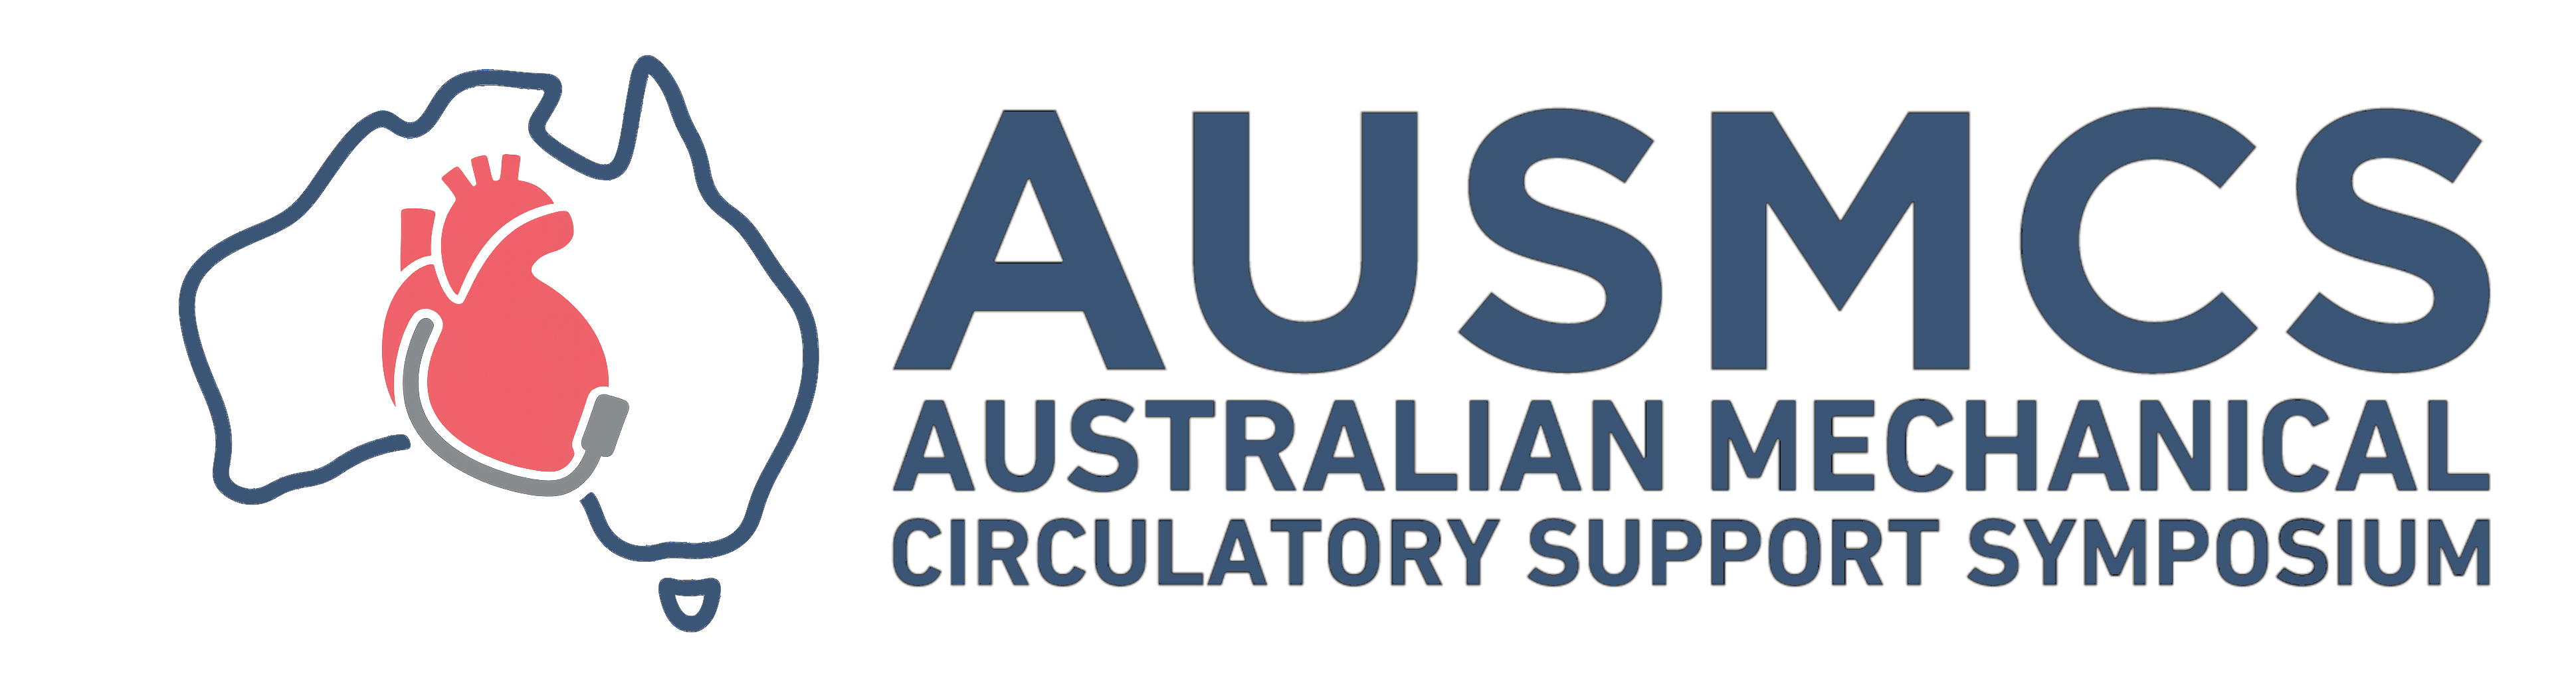

# Intro to AI — Workshop

We will build a small neural network to classify breast cancer from tabular features. Follow the headings; short notes appear before each code block. Cells labeled **Your turn** invite you to edit code, followed by collapsible solutions.

## 1. Environment Setup
First, we will just install some of the packages that will allow us to do the machine learning, without having to write all of the algorithms from scratch.
Don't forget to run each code chunk as we go through starting from the one immediately below!


In [14]:
#<----- run each code chunk by clicking the "play" button here. Once the code has finished running, the button will stop spinning. It may take a minute or so, first time
%pip install --upgrade \
  "scikit-learn>=1.6,<1.8" \
  "umap-learn==0.5.8" \
  "scikeras==0.13.0"

In [5]:
import sklearn
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

from keras.models import Sequential
from keras.layers import Dense, Activation
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Nadam

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
print('Versions:', 'sklearn', sklearn.__version__, '| tf', tf.__version__)


Versions: sklearn 1.5.2 | tf 2.19.0


## 2. Load and Inspect the Data
We use the scikit-learn *breast_cancer* dataset (diagnostic features).

The dataset has the following features related to the size of an abnormality shown on a radiological scan:


* radius (mean)
* texture (mean)
* perimeter (mean)
* area (mean)
* smoothness (mean)
* compactness (mean)
* concavity (mean)
* concave points (mean)
* symmetry (mean)
* fractal dimension (mean)
* radius (standard error)
* texture (standard error)
* perimeter (standard error)
* area (standard error)
* smoothness (standard error)
* compactness (standard error)
* concavity (standard error)
* concave points (standard error)
* symmetry (standard error)
* fractal dimension (standard error)
* radius (worst)
* texture (worst)
* perimeter (worst)
* area (worst)
* smoothness (worst)
* compactness (worst)
* concavity (worst)
* concave points (worst)
* symmetry (worst)
* fractal dimension (worst)

We load scikit-learn's `breast_cancer` dataset and create `X` (features) and `y` (labels). Edit the **Your turn** cell by double-clickign to explore column names and a small slice. Don't forget, the solution is available via below the code chunk


In [6]:
# Load dataset
bunch = datasets.load_breast_cancer()
X = pd.DataFrame(bunch.data, columns=bunch.feature_names) #save our column names from the dataset
y = pd.Series(bunch.target, name='target') #save our target (breast cancer yes/no)
print('X shape:', X.shape, '| y shape:', y.shape) #let's look at the shape


X shape: (569, 30) | y shape: (569,)


The first number of "shape" is the row count, the second number is the column count, you should see `(596,30)`

**Your turn 2.1.** Peek at the columns and a small slice of the data.

In [2]:
# TODO: Print the column names and show the first 5 rows of 5 columns
# 1) print the column names
print(___) #note, you must not leave any of the underscores from each of these "Your turn" blocks, otherwise the code won't run. Replace them with the appropriate values.

# 2) show a slice
X.iloc[___, ___] #this indexes the row and column of x. you can use : to set a range e.g x.iloc[0:5,0] will show the first 5 rows of the first column


NameError: name 'X' is not defined


<details>
<summary><em>Solution</em></summary>

```python
print(X.columns.tolist())
X.iloc[0:5, 0:5]
```
</details>


## 3. Pre-processing (Min–Max scaling)
In this case, all of our data is numerical, we don’t have to worry about categorical or ordinal conversion. Ordinarily, we would look at the distribution of data in each column to identify outliers. However, in the interest of time we have done this for you.



Neural networks train faster and are more stable when features are on similar scales. Min–Max scaling maps each feature to [0,1], which stabilises training and prevents wide-range features from dominating.

The equation for minmax scaling is
\begin{equation}
x' = \frac{x-x_{min}}{x_{max}-x_{min}}
\end{equation}


In [7]:
# Scale features to [0, 1]
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) #this squishes all of our data to between 0 and 1 based on ONLY the data in its own column.
# Sanity check
X_scaled.iloc[0:3, 0:5] #check the first 3 rows of the first 5 columns


mean radius  mean texture  mean perimeter  mean area  mean smoothness
0     0.521037      0.022658        0.545989   0.363733         0.593753
1     0.643144      0.272574        0.615783   0.501591         0.289880
2     0.601496      0.390260        0.595743   0.449417         0.514309

**Your turn 3.1.** Verify that each column's min/max is within [0, 1].

In [ ]:
# TODO: Compute per-column min and max to verify scaling
col_mins = X_scaled.min(axis=0) #find the minimum of each column
col_maxs = ___ #find the maximum of each column
pd.DataFrame({'min': col_mins, 'max': col_maxs}).head() #put it in a dataframe for us to see



<details>
<summary><em>Solution</em></summary>

```python
col_mins = X_scaled.min(axis=0)
col_maxs = X_scaled.max(axis=0)
pd.DataFrame({'min': col_mins, 'max': col_maxs}).head()
```
</details>


## 4. Train/Test Split

We create a stratified train/test split (20/80) to evaluate generalisation on unseen data. 20% is little training data for most real-world applications, but  this is an easy problem to solve.


In [8]:
X_train, X_test, y_train, y_test = train_test_split( #Split our data into X_train, X_test, y_train, y_test.
    X_scaled, y, test_size=0.8, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape #let's verify we have split 80/20


((113, 30), (456, 30))

## 5. Define the Neural Network

Let’s start building our model. In this case, we will build a neural network with three hidden layers. The network architecture will be 30 inputs → Layer one (with 30 nodes) → Layer two (with 20 nodes) → Layer three (with 10 nodes) → Output layer (1 node)

Architecture (same as *FirstModel* baseline):  
- Input: 30 features  
- Hidden layers: 30 → 20 → 10 units, **ELU** activations  
- Output: 1 unit with **sigmoid** activation (binary classification)

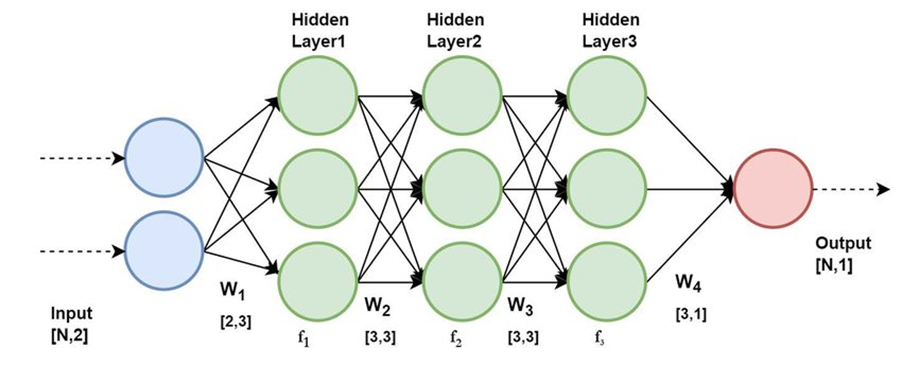

Lets set a few hyperparameters to change how the model will learn
**Hyperparameters to start with**
- EPOCHS = 10 - how many cycles the model will train
- BATCH = 100 - how many patients we will load into the model at a time
- LR = 0.01 (Nadam optimiser) - How fast our model will learn


Hyperparameters (`EPOCHS`, `BATCH`, `LR`) are set just below.
When building the model, we build it layer by layer in the code below.
`Sequential` tells the code we are building the model layer by layer.
`Dense` is a hidden layer of neurons with weights and biases
`Activation` is our activation layer, in this case an `elu` activation


In [9]:
EPOCHS = 10
BATCH = 100
LR = 0.01

def create_model(layer1=30, layer2=20, layer3=10, learning_rate=LR): #This is where we define the width of each hidden layer
    model = Sequential() #Sequential builds the model layer by layer
    model.add(Dense(units=layer1, input_dim=X_train.shape[1])) #Here we define the first hidden layer. input_dim = X_train.shape[1] just tells the model that our input layer is the same width as the number of columns we have
    model.add(Activation("elu")) #Here we add our elu activation
    model.add(Dense(units=layer2)) #Another hidden layer, 20 wide
    model.add(Activation("elu")) #Another activation
    model.add(Dense(units=layer3)) #you get the picture
    model.add(Activation("elu"))
    model.add(Dense(1, activation="sigmoid")) #This is our output layer, it uses a sigmoid output to squish our variables to between 1 and 0, just like logistic regression.
    model.compile(
        optimizer=Nadam(learning_rate=learning_rate), #The optimizer tells our model how big a step to take when updating the weights between epochs
        loss="binary_crossentropy", #this is a loss function that is perfect for binary problems
        metrics=["accuracy", "Precision", "Recall", "AUC"] #this just sets a few metrics we can use to see how our model is performing
    )
    return model


The optimizer in the compile function tells our model how quickly it can learn by adjusting the step rate. The loss tells us how to calculate the error between the truth and our predictions. The metrics argument simply builds in some metrics to keep track of while the model is learning.

**Your turn 5.1.** Adjust `EPOCHS`, `BATCH`, or `LR` and observe effects on accuracy and AUC.

## 6. Train and Validate





Lets train our model using the `fit` method, and see how well it predicts the test data. We can review the model loss and accuracy curves. Reported metrics include Accuracy, Precision, Recall, and AUC on the test set.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


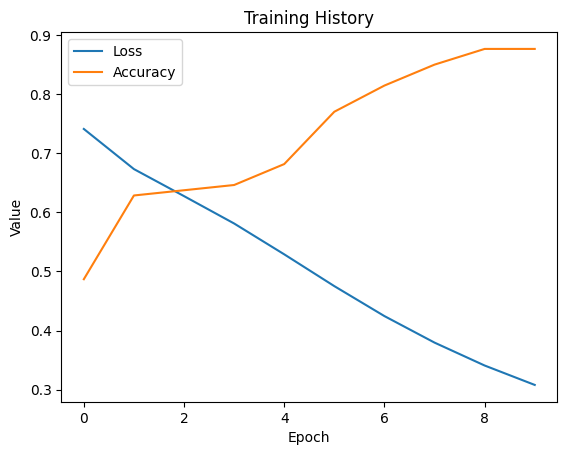

Test metrics (loss, acc, Precision, Recall, AUC): [0.359, 0.831, 0.789, 0.997, 0.961]


In [10]:
model = create_model()
history = model.fit( #this code sets it up so we start training our model, and track its progress during each step
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)

# Plot training curves - this code is all related to creating a plot
plt.figure()
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history.get("accuracy", []), label="Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend(); plt.title("Training History")
plt.show()

eval_scores = model.evaluate(X_test, y_test, verbose=0) #This code runs our trained model on the test data to produce our metrics
print("Test metrics (loss, acc, Precision, Recall, AUC):", [round(s, 3) for s in eval_scores]) #This code just prints our metrics outcome and contains some formatting for readability



**You may observe a plot like this:**

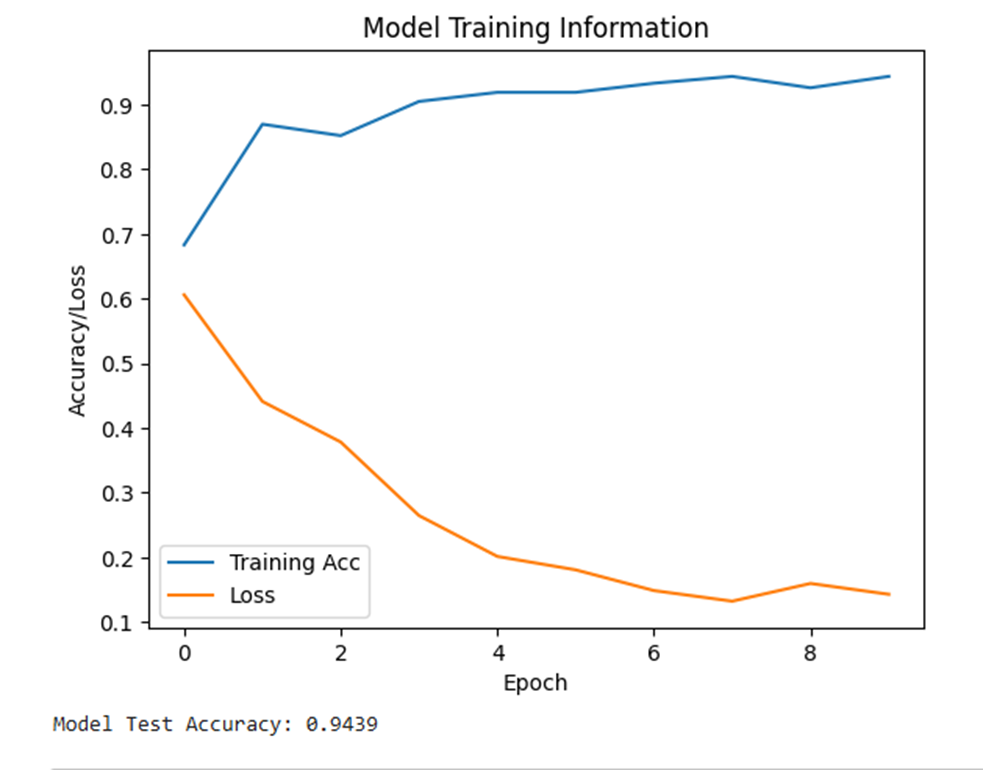

**Your turn 6.1.** Modify hyperparameters and architecture, then retrain. (Aim: observe effects on validation AUC.)

In [ ]:
# TODO:
# (a) Set new hyperparameters
EPOCHS = ___     # e.g., 20
BATCH = ___      # e.g., 64
LR = ___         # e.g., 0.005

# (b) Choose new hidden layer widths
h1, h2, h3 = ___, ___, ___  # e.g., 32, 16, 8

# (c) Build, train, and evaluate the model
model2 = create_model(layer1=h1, layer2=h2, layer3=h3, learning_rate=LR)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)

# Plot
plt.figure()
plt.plot(history2.history["loss"], label="Loss")
plt.plot(history2.history.get("accuracy", []), label="Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend(); plt.title("Training History (Custom)")
plt.show()

eval_scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("Custom model — Test metrics (loss, acc, Precision, Recall, AUC):", [round(s, 3) for s in eval_scores2])



<details>
<summary><em>Solution</em></summary>

```python
# (a) Hyperparameters
EPOCHS = 20
BATCH = 64
LR = 0.005

# (b) Layer widths
h1, h2, h3 = 32, 16, 8

# (c) Train/eval
model2 = create_model(layer1=h1, layer2=h2, layer3=h3, learning_rate=LR)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)

plt.figure()
plt.plot(history2.history["loss"], label="Loss")
plt.plot(history2.history.get("accuracy", []), label="Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Value"); plt.legend(); plt.title("Training History (Custom)")
plt.show()

eval_scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("Custom model — Test metrics (loss, acc, Precision, Recall, AUC):", [round(s, 3) for s in eval_scores2])
```
</details>


**Your turn 6.2.** Overlay the training curves from the baseline model and your custom model to compare performance.

In [ ]:
# TODO: Overlay baseline (history) and custom (history2) curves on the metric of your choice. Don't forget the labels and titles of the plot
plt.figure()
metric = ___     # e.g., "accuracy", "Precision", "Recall", "AUC"
if 'history' in globals() and hasattr(history, 'history'):
    plt.plot(history.history.get(metric, []), label=___)
if 'history2' in globals() and hasattr(history2, 'history'):
    plt.plot(history2.history.get(metric, []), label=___)
plt.xlabel("Epoch"); plt.ylabel(metric); plt.legend(); plt.title(___)
plt.show()



<details>
<summary><em>Solution</em></summary>

```python
plt.figure()
metric = "accuracy"
plt.plot(history.history.get(metric, []), label="Baseline Acc")
plt.plot(history2.history.get(metric, []), label="Custom Acc")
plt.xlabel("Epoch"); plt.ylabel(metric); plt.legend(); plt.title("Accuracy Comparison")
plt.show()
```
</details>


## 7. Cross-Validation (compact)

We can get more insight into our model by using cross-validation. Cross validation uses all of our data iteratively for training and testing by splitting it up. In this case, we use five-fold cross-validation, splitting the data into 5 sets, training on fold 1-4, and testing on fold 5. After the first fold, we then move to train on folds 2-5 and test on fold 1, and so on. This gives us information about the average model performance across the train/test splits.


In [11]:
sk_model = KerasClassifier( #this is what we call a wrapper, it takes our existing model and makes it easier to use with other software packages.
    model=create_model,
    epochs=EPOCHS,
    batch_size=BATCH
)

cv_results = cross_validate( #This code performs our cross-validation and stores each validation in cv_results
    sk_model, X_scaled, y,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    cv=5, verbose=0, n_jobs=None, error_score='raise'
)
summary = {k: (v.mean(), v.std()) for k, v in { #This just formats all of our results so when we print it, it is easier to read
    'accuracy': cv_results['test_accuracy'],
    'precision': cv_results['test_precision'],
    'recall': cv_results['test_recall'],
    'roc_auc': cv_results['test_roc_auc']
}.items()}

for metric, (m, s) in summary.items(): #this prints out the mean and standard deviation of each of our metrics
    print(f"{metric}: {m:.3f} ± {s:.3f}")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.6400 - Precision: 0.7011 - Recall: 0.6895 - accuracy: 0.6301 - loss: 0.6402
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9661 - Precision: 0.9314 - Recall: 0.9062 - accuracy: 0.8994 - loss: 0.4105
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9730 - Precision: 0.9388 - Recall: 0.9062 - accuracy: 0.9052 - loss: 0.2795
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9783 - Precision: 0.9551 - Recall: 0.9004 - accuracy: 0.9119 - loss: 0.2197
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9833 - Precision: 0.9644 - Recall: 0.9073 - accuracy: 0.9218 - loss: 0.1876
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9865 - Precision: 0.9713 - Recall: 0.9132 - accuracy: 0.9296 - loss: 0.1623
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9894 - Precision: 0.9685 - Recall: 0.9177 - accuracy: 0.9307 - loss: 0.1380
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9915 - Precisio

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.7469 - Precision: 0.7230 - Recall: 0.8179 - accuracy: 0.6917 - loss: 0.5895
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9548 - Precision: 0.9078 - Recall: 0.9145 - accuracy: 0.8897 - loss: 0.3516
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9726 - Precision: 0.9430 - Recall: 0.9165 - accuracy: 0.9142 - loss: 0.2397
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9781 - Precision: 0.9556 - Recall: 0.9034 - accuracy: 0.9148 - loss: 0.1849
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9834 - Precision: 0.9516 - Recall: 0.9404 - accuracy: 0.9339 - loss: 0.1584
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9863 - Precision: 0.9550 - Recall: 0.9561 - accuracy: 0.9452 - loss: 0.1420
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.9860 - Precision: 0.9548 - Recall: 0.9639 - accuracy: 0.9497 - loss: 0.1239
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9879 - Precisio

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.5017 - Precision: 0.6454 - Recall: 0.8278 - accuracy: 0.6056 - loss: 0.6739
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9318 - Precision: 0.8890 - Recall: 0.9076 - accuracy: 0.8690 - loss: 0.4773
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9503 - Precision: 0.9177 - Recall: 0.9046 - accuracy: 0.8872 - loss: 0.3296
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9629 - Precision: 0.9360 - Recall: 0.9114 - accuracy: 0.9040 - loss: 0.2468
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9733 - Precision: 0.9463 - Recall: 0.9181 - accuracy: 0.9149 - loss: 0.2052
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9817 - Precision: 0.9531 - Recall: 0.9360 - accuracy: 0.9302 - loss: 0.1606
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9881 - Precision: 0.9522 - Recall: 0.9780 - accuracy: 0.9549 - loss: 0.1236
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9919 - Precisio

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.6657 - Precision: 0.7168 - Recall: 0.4999 - accuracy: 0.5952 - loss: 0.6543
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9311 - Precision: 0.8811 - Recall: 0.8655 - accuracy: 0.8491 - loss: 0.4809
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9591 - Precision: 0.9213 - Recall: 0.8958 - accuracy: 0.8918 - loss: 0.3339
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9723 - Precision: 0.9403 - Recall: 0.9083 - accuracy: 0.9102 - loss: 0.2376
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9788 - Precision: 0.9531 - Recall: 0.9241 - accuracy: 0.9273 - loss: 0.1881
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9842 - Precision: 0.9635 - Recall: 0.9393 - accuracy: 0.9424 - loss: 0.1575
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9883 - Precision: 0.9501 - Recall: 0.9531 - accuracy: 0.9421 - loss: 0.1357
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9909

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - AUC: 0.5713 - Precision: 0.7372 - Recall: 0.8631 - accuracy: 0.7163 - loss: 0.6508
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9564 - Precision: 0.8870 - Recall: 0.9401 - accuracy: 0.8880 - loss: 0.3976
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9664 - Precision: 0.8746 - Recall: 0.9485 - accuracy: 0.8804 - loss: 0.2824
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9858 - Precision: 0.9532 - Recall: 0.9613 - accuracy: 0.9465 - loss: 0.1749
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9910 - Precision: 0.9579 - Recall: 0.9668 - accuracy: 0.9529 - loss: 0.1309
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9942 - Precision: 0.9670 - Recall: 0.9721 - accuracy: 0.9620 - loss: 0.1021
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9963 - Precision: 0.9674 - Recall: 0.9815 - accuracy: 0.9679 - loss: 0.0824
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.9940 - Precisio

**Your turn 7.1.** Change the number of folds and add `n_jobs` parallelism. Compare mean AUC.

In [ ]:
# TODO: Adjust folds and parallelism
folds = ___        # e.g., 10
workers = ___      # e.g., None or -1 for all CPUs

sk_model_cv = KerasClassifier(model=create_model, epochs=EPOCHS, batch_size=BATCH)
cv_results2 = cross_validate(
    sk_model_cv, X_scaled, y,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    cv=folds, verbose=0, n_jobs=workers, error_score='raise'
)
print("AUC (mean):", cv_results2['test_roc_auc'].mean())



<details>
<summary><em>Solution</em></summary>

```python
folds = 10
workers = None   # use -1 on local runtimes; Colab may ignore

sk_model_cv = KerasClassifier(model=create_model, epochs=EPOCHS, batch_size=BATCH)
cv_results2 = cross_validate(
    sk_model_cv, X_scaled, y,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    cv=folds, verbose=0, n_jobs=workers, error_score='raise'
)
print("AUC (mean):", cv_results2['test_roc_auc'].mean())
```
</details>


## 8. Feature Importance (Permutation Importance)

Permutation feature importance looks at different combinations of features to see how they affect overall model accuracy. Here we have plotted the top 5 performing features. The further to the right the feature is, the more it contributes to improved accuracy.


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.8100 - Precision: 0.8392 - Recall: 0.1780 - accuracy: 0.4712 - loss: 0.6767
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.3867 - Precision: 0.6226 - Recall: 1.0000 - accuracy: 0.6248 - loss: 0.7604
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.7237 - Precision: 0.6264 - Recall: 1.0000 - accuracy: 0.6307 - loss: 0.6402
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8388 - Precision: 0.6507 - Recall: 1.0000 - accuracy: 0.6676 - loss: 0.5692
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8891 - Precision: 0.6838 - Recall: 1.0000 - accuracy: 0.7138 - loss: 0.5103
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.9171 - Precision: 0.7529 - Recall: 1.0000 - accuracy: 0.7969 - loss: 0.4545
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9350 - Precision: 0.7961 - Recall: 0.9906 - accuracy: 0.8371 - loss: 0.4021
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.9481 - Precisio

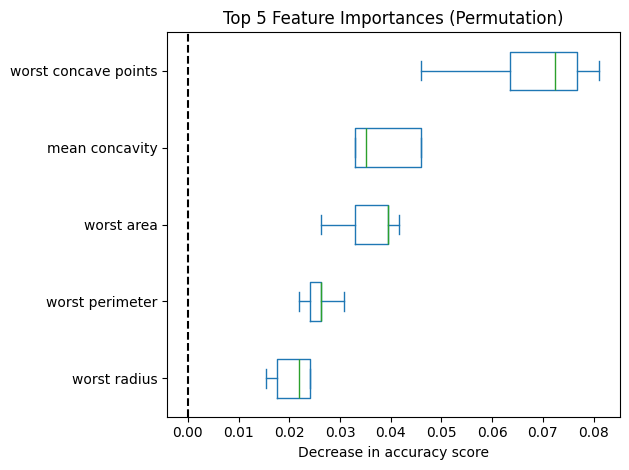

In [12]:
sk_model.fit(X_train, y_train) #We refit our model
pi = permutation_importance(sk_model, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE) #we run permutation feature importance, shuffling the features 5 times

sorted_idx = pi.importances_mean.argsort() #We sort the most important features to the least important
top_idx = sorted_idx[-5:] #We only keep the top 5 features
importances = pd.DataFrame(pi.importances[top_idx].T, columns=X.columns[top_idx]) #We put the features in a nice data frame with column names

ax = importances.plot.box(vert=False, whis=10) #Then we just plot the feature importances as a graph
ax.set_title("Top 5 Feature Importances (Permutation)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


**Your turn 8.1.** Increase `n_repeats` and change how many top features are displayed.

In [ ]:
# TODO: Set repeats and top-k
repeats = ___   # e.g., 10
top_k = ___     # e.g., 8

sk_model.fit(X_train, y_train) #Fit model
pi2 = permutation_importance(sk_model, X_test, y_test, n_repeats=repeats, random_state=RANDOM_STATE) #Feature importance
sorted_idx2 = pi2.importances_mean.argsort() #Sort features
top_idx2 = sorted_idx2[-top_k:] #keep top K features
importances2 = pd.DataFrame(pi2.importances[top_idx2].T, columns=X.columns[top_idx2]) #nice data frame
ax = importances2.plot.box(vert=False, whis=10) #plot
ax.set_title(f"Top {top_k} Feature Importances (Permutation, repeats={repeats})")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()



<details>
<summary><em>Solution</em></summary>

```python
repeats = 10
top_k = 8

sk_model.fit(X_train, y_train)
pi2 = permutation_importance(sk_model, X_test, y_test, n_repeats=repeats, random_state=RANDOM_STATE)
sorted_idx2 = pi2.importances_mean.argsort()
top_idx2 = sorted_idx2[-top_k:]
importances2 = pd.DataFrame(pi2.importances[top_idx2].T, columns=X.columns[top_idx2])
ax = importances2.plot.box(vert=False, whis=10)
ax.set_title(f"Top {top_k} Feature Importances (Permutation, repeats={repeats})")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
```
</details>


## 9. Exercises

1. Try `relu` instead of `elu`. What changes in training dynamics?  
2. Reduce/increase `LR`. When does training become unstable or too slow?  
3. Change layer widths to (32, 16, 8). Does AUC improve?  
4. Replace `MinMaxScaler` with `StandardScaler` and compare results.
5. Add `Dropout` (e.g., 0.1–0.3) after hidden layers. Does it help generalisation?  

More information about dropout can be found in [the Keras API Documents](https://keras.io/api/layers/regularization_layers/dropout/)

<details>
<summary><em>Solutions</em></summary>

**1) `relu` vs `elu`**
```python
from keras.layers import Dropout

def create_model_relu(layer1=30, layer2=20, layer3=10, learning_rate=LR):
    m = Sequential()
    m.add(Dense(units=layer1, input_dim=X_train.shape[1]))
    m.add(Activation("relu"))
    m.add(Dense(units=layer2))
    m.add(Activation("relu"))
    m.add(Dense(units=layer3))
    m.add(Activation("relu"))
    m.add(Dense(1, activation="sigmoid"))
    m.compile(optimizer=Nadam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(name="Precision"),
                       tf.keras.metrics.Recall(name="Recall"), tf.keras.metrics.AUC(name="AUC")])
    return m

model_relu = create_model_relu()
_ = model_relu.fit(X_train, y_train, validation_data=(X_test, y_test),
                   epochs=EPOCHS, batch_size=BATCH, verbose=0)
print("ReLU AUC:", model_relu.evaluate(X_test, y_test, verbose=0)[-1])
```

**2) Learning rate sensitivity**
```python
for lr in [0.0005, 0.001, 0.005, 0.01]:
    m = create_model(learning_rate=lr)
    _ = m.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=EPOCHS, batch_size=BATCH, verbose=0)
    print(f"LR={lr} AUC:", m.evaluate(X_test, y_test, verbose=0)[-1])
```

**3) Widths (32,16,8)**
```python
m = create_model(layer1=32, layer2=16, layer3=8, learning_rate=LR)
_ = m.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=EPOCHS, batch_size=BATCH, verbose=0)
print("AUC (32,16,8):", m.evaluate(X_test, y_test, verbose=0)[-1])
```

**4) Add Dropout**
```python
from keras.layers import Dropout

def create_model_dropout(layer1=30, layer2=20, layer3=10, p=0.2, learning_rate=LR):
    m = Sequential()
    m.add(Dense(units=layer1, input_dim=X_train.shape[1]))
    m.add(Activation("elu")); m.add(Dropout(p))
    m.add(Dense(units=layer2)); m.add(Activation("elu")); m.add(Dropout(p))
    m.add(Dense(units=layer3)); m.add(Activation("elu")); m.add(Dropout(p))
    m.add(Dense(1, activation="sigmoid"))
    m.compile(optimizer=Nadam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(name="Precision"),
                       tf.keras.metrics.Recall(name="Recall"), tf.keras.metrics.AUC(name="AUC")])
    return m

m = create_model_dropout(p=0.2)
_ = m.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=EPOCHS, batch_size=BATCH, verbose=0)
print("Dropout AUC:", m.evaluate(X_test, y_test, verbose=0)[-1])
```

**5) StandardScaler vs MinMaxScaler**
```python
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)

Xtr, Xte, ytr, yte = train_test_split(X_std, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
m = create_model()
_ = m.fit(Xtr, ytr, validation_data=(Xte, yte),
          epochs=EPOCHS, batch_size=BATCH, verbose=0)
print("AUC (StandardScaler):", m.evaluate(Xte, yte, verbose=0)[-1])
```
</details>
